In [197]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

In [198]:
data2019 = requests.get('https://api.census.gov/data/2018/abscs?get=NAME,GEO_ID,NAICS2017_LABEL,SEX,ETH_GROUP,RACE_GROUP,VET_GROUP,FIRMPDEMP&for=state:*&NAICS2017=00&key=a4bcb4614372e8f229066cbce694ccdb6b558ef4').json()

In [199]:
data2020 = requests.get('https://api.census.gov/data/2019/abscs?get=NAME,GEO_ID,NAICS2017_LABEL,SEX,ETH_GROUP,RACE_GROUP,VET_GROUP,FIRMPDEMP&for=state:*&NAICS2017=00&key=a4bcb4614372e8f229066cbce694ccdb6b558ef4').json()

In [200]:
companysummarystate2019 = pd.DataFrame (data2019[1:], columns= data2019[0])

In [201]:
companysummarystate2020 = pd.DataFrame(data2020[1:], columns = data2020[0])

In [202]:
companysummarystate2019.drop(columns = ['GEO_ID','NAICS2017_LABEL','NAICS2017','state'], inplace=True)

In [203]:
companysummarystate2020.drop(columns = ['GEO_ID','NAICS2017_LABEL','NAICS2017','state'], inplace=True)

In [204]:
companysummarystate2019.head()

,NAME,SEX,ETH_GROUP,RACE_GROUP,VET_GROUP,FIRMPDEMP
0,Mississippi,002,029,00,003,0
1,Mississippi,003,029,00,003,466
2,Mississippi,004,029,00,003,572
3,Mississippi,001,001,30,003,926
4,Mississippi,096,096,96,096,37489


In [205]:
companysummarystate2020.head()

,NAME,SEX,ETH_GROUP,RACE_GROUP,VET_GROUP,FIRMPDEMP
0,Mississippi,001,028,00,001,93
1,Mississippi,003,028,00,001,0
2,Mississippi,002,029,50,001,0
3,Mississippi,003,029,50,001,51
4,Mississippi,001,001,60,001,2489


In [206]:
companysummarystate2019.FIRMPDEMP.isna().value_counts()

False    9668
Name: FIRMPDEMP, dtype: int64

In [207]:
companysummarystate2020.FIRMPDEMP.isna().value_counts()

False    9641
Name: FIRMPDEMP, dtype: int64

In [208]:
statemerge = companysummarystate2019.merge(companysummarystate2020, on=['NAME', 'SEX', 'ETH_GROUP', 'RACE_GROUP', 'VET_GROUP'], how='inner', suffixes = ('_2019', '_2020') )

The totals for each column are 001, except Race_Group which is 00.
Make sure that you filter for totals on all the other columns except for the ones you are looking at fo

In [209]:
statemerge

,NAME,SEX,ETH_GROUP,RACE_GROUP,VET_GROUP,FIRMPDEMP_2019,FIRMPDEMP_2020
0,Mississippi,003,029,00,003,466,334
1,Mississippi,004,029,00,003,572,0
2,Mississippi,001,001,30,003,926,801
3,Mississippi,096,096,96,096,37489,37057
4,Mississippi,002,001,00,001,6659,7751
...,...,...,...,...,...,...,...
9133,Minnesota,002,029,00,003,0,0
9134,Minnesota,003,029,00,003,941,1128
9135,Minnesota,004,029,00,003,0,1877
9136,Minnesota,001,001,30,003,0,3025


In [210]:
pd.options.mode.chained_assignment = None

In [211]:
#changing data to numeric values for easier plotting
statemerge['FIRMPDEMP_2020'] = pd.to_numeric(statemerge['FIRMPDEMP_2020'])
statemerge['FIRMPDEMP_2019'] = pd.to_numeric(statemerge['FIRMPDEMP_2019'])

In [212]:
#filtering the data so i get data for minority women owned firms
onestatemerge = statemerge.loc[(statemerge['SEX'] == '002') & (statemerge['ETH_GROUP'] == '001') & (statemerge['RACE_GROUP'] == '90') & (statemerge['VET_GROUP'] == '001')]
print(onestatemerge)

                      NAME  SEX ETH_GROUP RACE_GROUP VET_GROUP  \
123            Mississippi  002       001         90       001   
279               Missouri  002       001         90       001   
422                Montana  002       001         90       001   
603               Nebraska  002       001         90       001   
839                 Nevada  002       001         90       001   
919          New Hampshire  002       001         90       001   
1174            New Jersey  002       001         90       001   
1245            New Mexico  002       001         90       001   
1534              New York  002       001         90       001   
1666        North Carolina  002       001         90       001   
1824          North Dakota  002       001         90       001   
2117                  Ohio  002       001         90       001   
2183              Oklahoma  002       001         90       001   
2362                Oregon  002       001         90       001   
2522      

In [213]:
#checking datatypes
result = onestatemerge.dtypes
print(result)

NAME              object
SEX               object
ETH_GROUP         object
RACE_GROUP        object
VET_GROUP         object
FIRMPDEMP_2019     int64
FIRMPDEMP_2020     int64
dtype: object


In [214]:
#changing state name data type so it can be plotted
onestatemerge['NAME'] = onestatemerge['NAME'].astype('|S')

In [215]:
#making sure state name data type changed
result = onestatemerge.dtypes
print(result)

NAME                |S20
SEX               object
ETH_GROUP         object
RACE_GROUP        object
VET_GROUP         object
FIRMPDEMP_2019     int64
FIRMPDEMP_2020     int64
dtype: object


Text(0, 0.5, 'Number of firms')

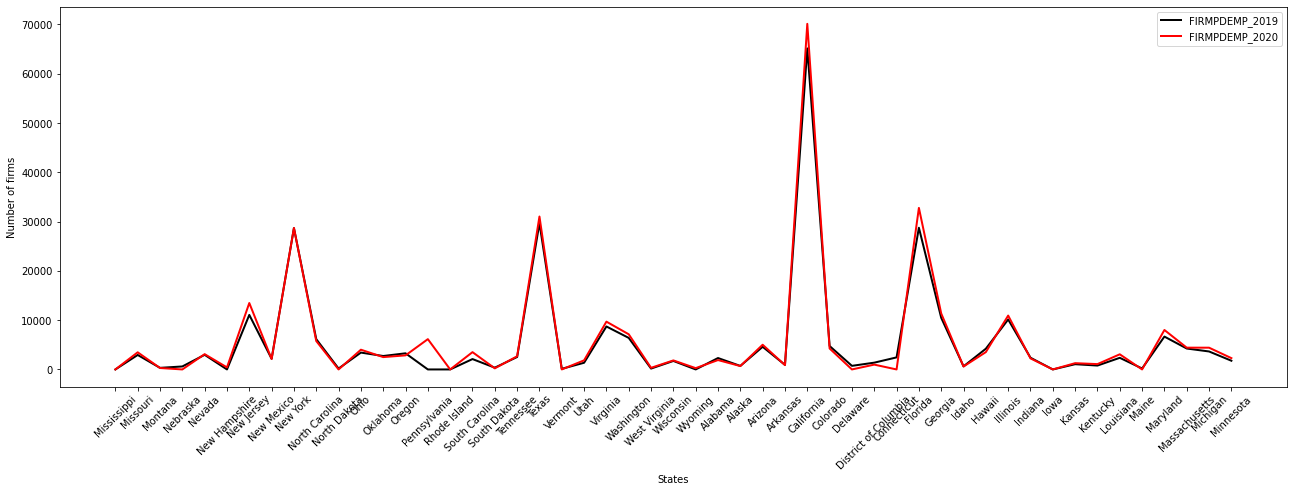

In [216]:
#plotting chart to find out how the number of businesses has changed from 2019 to 2020
plt.figure(figsize=(22, 8))
plt.plot( 'NAME', 'FIRMPDEMP_2019', data= onestatemerge, color='black', linewidth=2)
plt.plot( 'NAME', 'FIRMPDEMP_2020', data= onestatemerge, color='red', linewidth=2)
plt.legend()
plt.xlabel('States')
plt.xticks(rotation = 45)
spacing = 0.220
plt.subplots_adjust(bottom=spacing)
plt.ylabel('Number of firms')


In [217]:
womenstatemerge = onestatemerge = statemerge.loc[(statemerge['SEX'] == '002') & (statemerge['ETH_GROUP'] == '001') & (statemerge['RACE_GROUP'] == '00') & (statemerge['VET_GROUP'] == '001')]
print(onestatemerge)

                      NAME  SEX ETH_GROUP RACE_GROUP VET_GROUP  \
4              Mississippi  002       001         00       001   
290               Missouri  002       001         00       001   
379                Montana  002       001         00       001   
505               Nebraska  002       001         00       001   
833                 Nevada  002       001         00       001   
968          New Hampshire  002       001         00       001   
1130            New Jersey  002       001         00       001   
1214            New Mexico  002       001         00       001   
1479              New York  002       001         00       001   
1644        North Carolina  002       001         00       001   
1877          North Dakota  002       001         00       001   
1946                  Ohio  002       001         00       001   
2197              Oklahoma  002       001         00       001   
2318                Oregon  002       001         00       001   
2617      

In [218]:
menstatemerge = onestatemerge = statemerge.loc[(statemerge['SEX'] == '003') & (statemerge['ETH_GROUP'] == '001') & (statemerge['RACE_GROUP'] == '00') & (statemerge['VET_GROUP'] == '001')]
print(menstatemerge)

                      NAME  SEX ETH_GROUP RACE_GROUP VET_GROUP  \
5              Mississippi  003       001         00       001   
306               Missouri  003       001         00       001   
381                Montana  003       001         00       001   
500               Nebraska  003       001         00       001   
834                 Nevada  003       001         00       001   
980          New Hampshire  003       001         00       001   
1154            New Jersey  003       001         00       001   
1215            New Mexico  003       001         00       001   
1494              New York  003       001         00       001   
1661        North Carolina  003       001         00       001   
1878          North Dakota  003       001         00       001   
1959                  Ohio  003       001         00       001   
2198              Oklahoma  003       001         00       001   
2323                Oregon  003       001         00       001   
2500      

Text(0, 0.5, 'Number of firms')

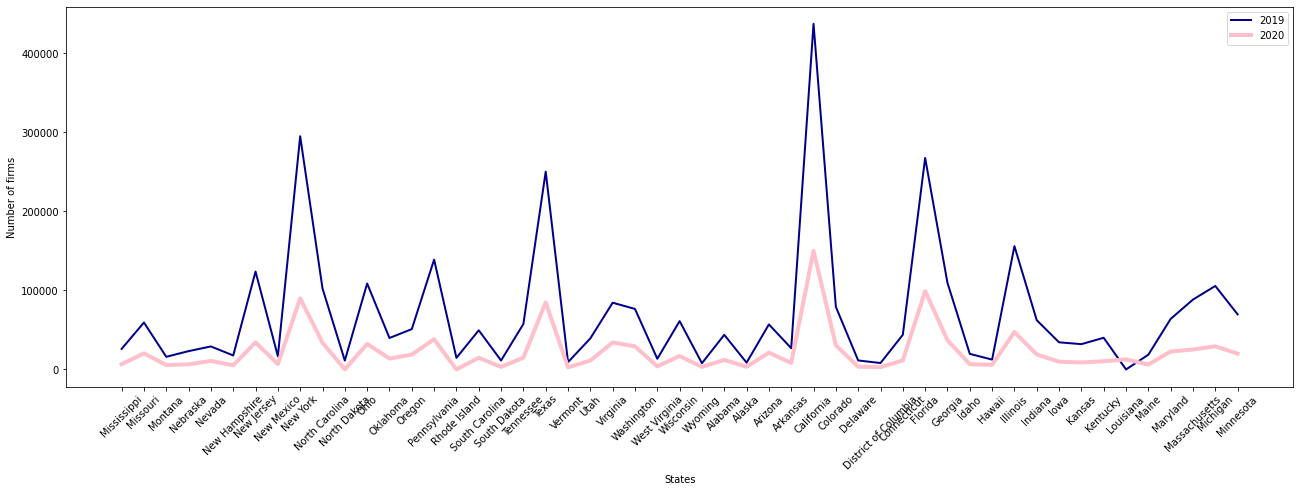

In [219]:
plt.figure(figsize=(22, 8))
plt.plot( 'NAME', 'FIRMPDEMP_2019', data= menstatemerge, color='darkblue', linewidth=2)
plt.plot( 'NAME', 'FIRMPDEMP_2019', data= womenstatemerge, color='pink', linewidth=4)
plt.legend(["2019", "2020"])
plt.xlabel('States')
plt.xticks(rotation = 45)
spacing = 0.220
plt.subplots_adjust(bottom=spacing)
plt.ylabel('Number of firms')


In [220]:
regions_to_states = {
    'South': ['West Virginia', 'District of Columbia', 'Maryland', 'Virginia',
              'Kentucky', 'Tennessee', 'North Carolina', 'Mississippi',
              'Arkansas', 'Louisiana', 'Alabama', 'Georgia', 'South Carolina',
              'Florida', 'Delaware'],
    'Southwest': ['Arizona', 'New Mexico', 'Oklahoma', 'Texas'],
    'West': ['Washington', 'Oregon', 'California', 'Nevada', 'Idaho', 'Montana',
             'Wyoming', 'Utah', 'Colorado', 'Alaska', 'Hawaii'],
    'Midwest': ['North Dakota', 'South Dakota', 'Nebraska', 'Kansas', 'Minnesota',
                'Iowa', 'Missouri', 'Wisconsin', 'Illinois', 'Michigan', 'Indiana',
                'Ohio'],
    'Northeast': ['Maine', 'Vermont', 'New York', 'New Hampshire', 'Massachusetts',
                  'Rhode Island', 'Connecticut', 'New Jersey', 'Pennsylvania']
}

In [221]:
# nefilter = statemerge[(statemerge['RACE_GROUP'] == '30') | (statemerge['RACE_GROUP'] == '40') | (statemerge['RACE_GROUP'] == '50')
# | (statemerge['RACE_GROUP'] == '70') & ((statemerge['NAME'] == 'New York') | (statemerge['NAME'] == 'Maine') | (statemerge['NAME'] == 'Vermont')
# | (statemerge['NAME'] == 'New Hampshire') | (statemerge['NAME'] == 'Massachusetts') | (statemerge['NAME'] == 'Rhode Island') 
# | (statemerge['NAME'] == 'Connecticut') | (statemerge['NAME'] == 'New Jersey') | (statemerge['NAME'] == 'Pennsylvanua'))]
# print(nefilter)

In [222]:
nefilter = statemerge[((statemerge['RACE_GROUP'] == '30') | (statemerge['RACE_GROUP'] == '40') | (statemerge['RACE_GROUP'] == '50')
| (statemerge['RACE_GROUP'] == '70')) & (statemerge['SEX'] == '001') & (statemerge['ETH_GROUP'] == '001') & (statemerge['VET_GROUP'] == '001') & (statemerge['NAME'].isin(regions_to_states['Northeast']))]
print(nefilter)

               NAME  SEX ETH_GROUP RACE_GROUP VET_GROUP  FIRMPDEMP_2019  \
910   New Hampshire  001       001         70       001               0   
922   New Hampshire  001       001         30       001           25432   
961   New Hampshire  001       001         40       001               0   
986   New Hampshire  001       001         50       001              17   
1027     New Jersey  001       001         50       001               0   
1096     New Jersey  001       001         30       001          147291   
1115     New Jersey  001       001         70       001             132   
1158     New Jersey  001       001         40       001            3636   
1445       New York  001       001         30       001          347785   
1484       New York  001       001         70       001               0   
1516       New York  001       001         40       001           10015   
1584       New York  001       001         50       001             372   
2507   Pennsylvania  001 

In [223]:
newhite2019 = nefilter.where(nefilter['RACE_GROUP'] == '30')['FIRMPDEMP_2019'].sum()
newhite2020 = nefilter.where(nefilter['RACE_GROUP'] == '30')['FIRMPDEMP_2020'].sum()

In [224]:
neblack2019 = nefilter.where(nefilter['RACE_GROUP'] == '40')['FIRMPDEMP_2019'].sum()
neblack2020 = nefilter.where(nefilter['RACE_GROUP'] == '40')['FIRMPDEMP_2020'].sum()

In [225]:
nenative2019 = nefilter.where(nefilter['RACE_GROUP'] == '50')['FIRMPDEMP_2019'].sum()
nenative2020 = nefilter.where(nefilter['RACE_GROUP'] == '50')['FIRMPDEMP_2020'].sum()

In [226]:
nehawaiian2019 = nefilter.where(nefilter['RACE_GROUP'] == '70')['FIRMPDEMP_2019'].sum()
nehawaiian2020 = nefilter.where(nefilter['RACE_GROUP'] == '70')['FIRMPDEMP_2020'].sum()

In [227]:
nebus = pd.DataFrame({'RACE':['WHITE', 'BLACK', 'NATIVE', 'HAWAIIAN'], '2019':[newhite2019, neblack2019, nenative2019, nehawaiian2019], '2020':[newhite2020, neblack2020, nenative2020, nehawaiian2020]})

<AxesSubplot:title={'center':'Top Business Owner Groups in the Northeast'}, xlabel='RACE', ylabel='Number of Businesses'>

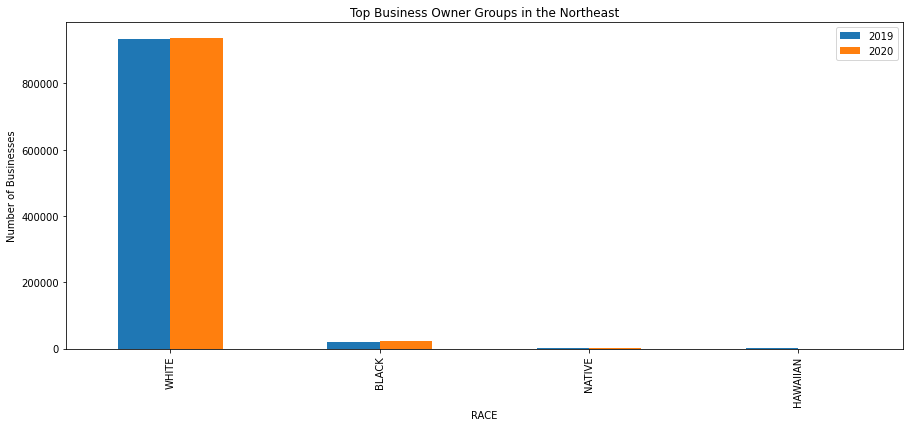

In [228]:
nebus.plot(x = 'RACE', y= ['2019', '2020'], ylabel = 'Number of Businesses', kind ='bar', title = 'Top Business Owner Groups in the Northeast', figsize=(15, 6))

In [229]:
wfilter = statemerge[((statemerge['RACE_GROUP'] == '30') | (statemerge['RACE_GROUP'] == '40') | (statemerge['RACE_GROUP'] == '50')
| (statemerge['RACE_GROUP'] == '70')) & (statemerge['SEX'] == '001') & (statemerge['ETH_GROUP'] == '001') & (statemerge['VET_GROUP'] == '001') & (statemerge['NAME'].isin(regions_to_states['West']))]
print(wfilter)

            NAME  SEX ETH_GROUP RACE_GROUP VET_GROUP  FIRMPDEMP_2019  \
351      Montana  001       001         70       001               0   
360      Montana  001       001         30       001           28546   
376      Montana  001       001         40       001              24   
384      Montana  001       001         50       001             303   
698       Nevada  001       001         50       001             225   
749       Nevada  001       001         30       001           41703   
770       Nevada  001       001         70       001               0   
838       Nevada  001       001         40       001             820   
2327      Oregon  001       001         40       001             668   
2342      Oregon  001       001         30       001           78993   
2402      Oregon  001       001         50       001             502   
2453      Oregon  001       001         70       001               0   
3766        Utah  001       001         40       001            

In [230]:
wwhite2019 = wfilter.where(wfilter['RACE_GROUP'] == '30')['FIRMPDEMP_2019'].sum()
wwhite2020 = wfilter.where(wfilter['RACE_GROUP'] == '30')['FIRMPDEMP_2020'].sum()

In [231]:
wblack2019 = wfilter.where(wfilter['RACE_GROUP'] == '40')['FIRMPDEMP_2019'].sum()
wblack2020 = wfilter.where(wfilter['RACE_GROUP'] == '40')['FIRMPDEMP_2020'].sum()

In [232]:
wnative2019 = wfilter.where(wfilter['RACE_GROUP'] == '50')['FIRMPDEMP_2019'].sum()
wnative2020 = wfilter.where(wfilter['RACE_GROUP'] == '50')['FIRMPDEMP_2020'].sum()

In [233]:
whawaiian2019 = wfilter.where(wfilter['RACE_GROUP'] == '70')['FIRMPDEMP_2019'].sum()
whawaiian2020 = wfilter.where(wfilter['RACE_GROUP'] == '70')['FIRMPDEMP_2020'].sum()

In [234]:
wbus = pd.DataFrame({'RACE':['WHITE', 'BLACK', 'NATIVE', 'HAWAIIAN'], '2019':[wwhite2019, wblack2019, wnative2019, whawaiian2019], '2020':[wwhite2020, wblack2020, wnative2020, whawaiian2020]})

<AxesSubplot:title={'center':'Top Business Owner Groups in the West'}, xlabel='RACE', ylabel='Number of Businesses (in millions)'>

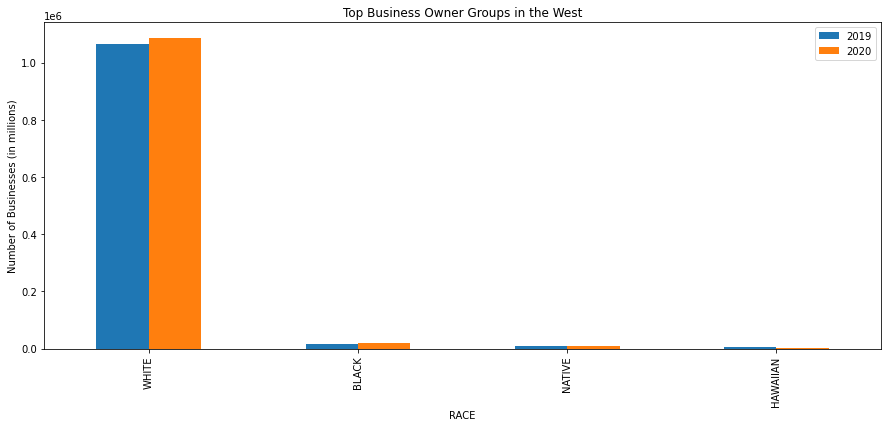

In [235]:
wbus.plot(x = 'RACE', y= ['2019', '2020'], ylabel = 'Number of Businesses (in millions)', kind ='bar', title = 'Top Business Owner Groups in the West', figsize=(15, 6))

In [236]:
sfilter = statemerge[((statemerge['RACE_GROUP'] == '30') | (statemerge['RACE_GROUP'] == '40') | (statemerge['RACE_GROUP'] == '50')
| (statemerge['RACE_GROUP'] == '70')) & (statemerge['SEX'] == '001') & (statemerge['ETH_GROUP'] == '001') & (statemerge['VET_GROUP'] == '001') & (statemerge['NAME'].isin(regions_to_states['South']))]
print(sfilter)

                      NAME  SEX ETH_GROUP RACE_GROUP VET_GROUP  \
35             Mississippi  001       001         50       001   
73             Mississippi  001       001         30       001   
92             Mississippi  001       001         70       001   
148            Mississippi  001       001         40       001   
1602        North Carolina  001       001         30       001   
1623        North Carolina  001       001         70       001   
1665        North Carolina  001       001         40       001   
1703        North Carolina  001       001         50       001   
2852        South Carolina  001       001         30       001   
2871        South Carolina  001       001         70       001   
2929        South Carolina  001       001         40       001   
2985        South Carolina  001       001         50       001   
3223             Tennessee  001       001         40       001   
3259             Tennessee  001       001         30       001   
3286      

In [237]:
swhite2019 = sfilter.where(sfilter['RACE_GROUP'] == '30')['FIRMPDEMP_2019'].sum()
swhite2020 = sfilter.where(sfilter['RACE_GROUP'] == '30')['FIRMPDEMP_2020'].sum()

In [238]:
sblack2019 = sfilter.where(sfilter['RACE_GROUP'] == '40')['FIRMPDEMP_2019'].sum()
sblack2020 = sfilter.where(sfilter['RACE_GROUP'] == '40')['FIRMPDEMP_2020'].sum()

In [239]:
snative2019 = sfilter.where(sfilter['RACE_GROUP'] == '50')['FIRMPDEMP_2019'].sum()
snative2020 = sfilter.where(sfilter['RACE_GROUP'] == '50')['FIRMPDEMP_2020'].sum()

In [240]:
shawaiian2019 = sfilter.where(sfilter['RACE_GROUP'] == '70')['FIRMPDEMP_2019'].sum()
shawaiian2020 = sfilter.where(sfilter['RACE_GROUP'] == '70')['FIRMPDEMP_2020'].sum()

In [241]:
sbus = pd.DataFrame({'RACE':['WHITE', 'BLACK', 'NATIVE', 'HAWAIIAN'], '2019':[swhite2019, sblack2019, snative2019, shawaiian2019], '2020':[swhite2020, sblack2020, snative2020, shawaiian2020]})

<AxesSubplot:title={'center':'Top Business Owner Groups in the South'}, xlabel='RACE', ylabel='Number of Businesses (in millions)'>

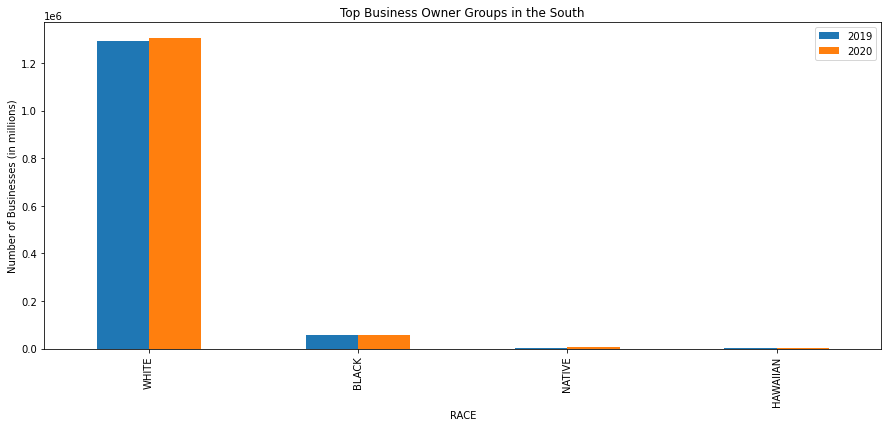

In [242]:
sbus.plot(x = 'RACE', y= ['2019', '2020'], ylabel = 'Number of Businesses (in millions)', kind ='bar', title = 'Top Business Owner Groups in the South', figsize=(15, 6))

In [243]:
mwfilter = statemerge[((statemerge['RACE_GROUP'] == '30') | (statemerge['RACE_GROUP'] == '40') | (statemerge['RACE_GROUP'] == '50')
| (statemerge['RACE_GROUP'] == '70')) & (statemerge['SEX'] == '001') & (statemerge['ETH_GROUP'] == '001') & (statemerge['VET_GROUP'] == '001') & (statemerge['NAME'].isin(regions_to_states['Midwest']))]
print(mwfilter)

              NAME  SEX ETH_GROUP RACE_GROUP VET_GROUP  FIRMPDEMP_2019  \
158       Missouri  001       001         50       001             248   
193       Missouri  001       001         30       001           92268   
232       Missouri  001       001         70       001               0   
294       Missouri  001       001         40       001            3106   
508       Nebraska  001       001         50       001             125   
587       Nebraska  001       001         70       001               0   
595       Nebraska  001       001         30       001           38694   
637       Nebraska  001       001         40       001               0   
1827  North Dakota  001       001         30       001           17599   
1864  North Dakota  001       001         40       001              37   
1888  North Dakota  001       001         50       001             163   
1937          Ohio  001       001         40       001            3163   
1997          Ohio  001       001     

In [244]:
mwwhite2019 = mwfilter.where(mwfilter['RACE_GROUP'] == '30')['FIRMPDEMP_2019'].sum()
mwwhite2020 = mwfilter.where(mwfilter['RACE_GROUP'] == '30')['FIRMPDEMP_2020'].sum()

In [245]:
mwblack2019 = mwfilter.where(mwfilter['RACE_GROUP'] == '40')['FIRMPDEMP_2019'].sum()
mwblack2020 = mwfilter.where(mwfilter['RACE_GROUP'] == '40')['FIRMPDEMP_2020'].sum()

In [246]:
mwnative2019 = mwfilter.where(mwfilter['RACE_GROUP'] == '50')['FIRMPDEMP_2019'].sum()
mwnative2020 = mwfilter.where(mwfilter['RACE_GROUP'] == '50')['FIRMPDEMP_2020'].sum()

In [247]:
mwhawaiian2019 = mwfilter.where(mwfilter['RACE_GROUP'] == '70')['FIRMPDEMP_2019'].sum()
mwhawaiian2020 = mwfilter.where(mwfilter['RACE_GROUP'] == '70')['FIRMPDEMP_2020'].sum()

In [248]:
mwbus = pd.DataFrame({'RACE':['WHITE', 'BLACK', 'NATIVE', 'HAWAIIAN'], '2019':[mwwhite2019, mwblack2019, mwnative2019, mwhawaiian2019], '2020':[mwwhite2020, mwblack2020, mwnative2020, mwhawaiian2020]})

<AxesSubplot:title={'center':'Top Business Owner Groups in the Midwest'}, xlabel='RACE', ylabel='Number of Businesses (in millions)'>

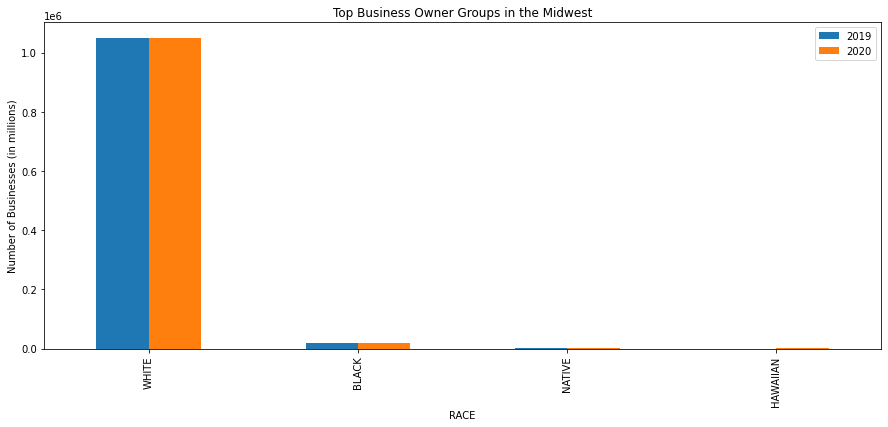

In [250]:
mwbus.plot(x = 'RACE', y= ['2019', '2020'], ylabel = 'Number of Businesses (in millions)', kind ='bar', title = 'Top Business Owner Groups in the Midwest', figsize=(15, 6))